# Lecture 6: Learning hyperparameters for GP. Active learning and Bayesian optimization.

## How to learn hyperparameters of GP model?

### Setting
* We need to determine parameters of the GP $f(\mathbf{x})\sim\text{GP}(m(\mathbf{x}),k(\mathbf{x},\mathbf{x}'))$.
* Let us assume that our model is parameterized as follows:
$$
\text{Mean } m(\mathbf{x})=a\mathbf{x}^2+b\mathbf{x}+c, \text{and}\\
\text{Covariance } k(\mathbf{x}_p,\mathbf{x}_q) = \sigma_y^2\exp{\left(−\frac{\left|\mathbf{x}_p−\mathbf{x}_q\right|^2}{2\ell^2}\right)} + \sigma_n^2\delta_{pq},
$$ 
where hyperparameters are $\mathbf{\theta} = \{a,b,c,\sigma_y,\sigma_n,\ell\}$.

* We want to be able to make inferences about all of the hyperparameters having the data $\mathcal{D}_{n} = {(\mathbf{x}_i,y_i),i = 1,\ldots,n}$.
* To do this we calculate the probability of the data given the hyperparameters. 
Denote $\mathbf \mu=\{m(x_i)\}$, $\Sigma=\{k(x_i,x_j)\}$.
Since by assumption the distribution of the data is Gaussian:
$$
L = \log{p(\mathbf{y}\mid\mathbf{x},\mathbf{\theta})} = -\frac12\log\left|\Sigma\right|-\frac{1}{2}(\mathbf{y}-\mathbf{\mu})^T\Sigma^{−1}(\mathbf{y}−\mathbf{\mu})− \frac n2\log(2\pi),
$$ we will call this expression as **log marginal likelihood**.
* We can now find the values of the hyperparameters which optimizes the marginal likelihood:
$$
\frac{\partial{L}}{\partial{\theta_m}} = -(\mathbf{y}-\mathbf{\mu})^T\Sigma^{−1}\frac{\partial m}{\partial\theta_m},\\
\frac{\partial{L}}{\partial{\theta_k}} = \frac{1}{2}\text{tr}\left(\Sigma^{−1}\frac{\partial \Sigma}{\partial\theta_k}\right) + \frac{1}{2}(\mathbf{y}-\mathbf{\mu})^T\Sigma^{-1}\frac{\partial \Sigma}{\partial\theta_k}\Sigma^{-1}(\mathbf{y}-\mathbf{\mu})
$$
where $\theta_m$ and $\theta_k$ are used to indicate hyperparameters of the mean and covariance functions respectively.
* This problem can be easily solved by numerical optimization methods such as L-BFGS.
* **Note:** there can be multiple optima of the marginal likelihood (each locally optimal $\theta$ corresponds to different interpretation of the data).

In the example below, we will see the result of finding GP model parameters with the use of maximum likelihood. 
As a function that we approximate, we take 
$$
f(x)=\frac{1}{2}\cos(2x)+\sin(0.9x)
$$
with the addition of noise $\sigma = 0.1$.

In manual mode one can try to match the parameters (```var``` and $\ell$ are parameter of the Gaussian kernel, $\sigma$ is noise value) to reduce the error.  In optimized mode they are calculated automatically -- we will find two different optima by setting different inital values for hyperparameters.
We use Python package ```GPy``` for all internal optimization, information about its work is shown in the table below.

In [4]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import GPy
from ipywidgets import interactive, interact, widgets
import scipy.spatial as SP

In [5]:
def f(x): return .5*np.cos(2*x) + np.sin(.9*x)

def GP_tune(variance, l, s, mode):
    np.random.seed(4)
    
    X = np.linspace(-5, 5, 20)[:, None]
    Xtest = np.linspace(-5, 5, 100)[:, None]
    Y = f(X) + np.random.normal(loc=0., scale=.1, size=(20, 1))
    
    k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=l)
    m = GPy.models.GPRegression(X, Y, k)
    m.Gaussian_noise = s
    if mode == 'Optimize 1':
        m.kern.variance = 1.
        m.Gaussian_noise = 1.5
        m.kern.lengthscale = 1.
        m.optimize('lbfgs')
    if mode == 'Optimize 2':
        m.kern.variance = 1.
        m.Gaussian_noise = .1
        m.kern.lengthscale = .1
        m.optimize()  
    figure, axes = plt.subplots(1,2, figsize=(16,10), tight_layout=True)
    m.plot(ax=axes[0])
    axes[0].set_title(
        'Error ='+str(round(np.linalg.norm(
            f(Xtest)-m.predict(Xtest)[0], ord=np.inf)/np.linalg.norm(f(Xtest), ord=np.inf),4)))
    print(m)

    n = 50

    kern = GPy.kern.RBF(1)
    model = GPy.models.GPRegression(X, Y, kern)
    model.kern.variance = 1.

    L = np.zeros((n,n))
    i = 0
    for gaussian_noise in np.linspace(1e-3, 0.07, n)[:, None]:
        j = 0
        model.Gaussian_noise = gaussian_noise
        for length in np.linspace(0.1, 3, n)[:, None]:
            model.kern.lengthscale = length
            L[i,j] = model.log_likelihood()
            j += 1
        i += 1 
    x_a = np.linspace(0.1, 3, n)
    y_a = np.linspace(1e-3, 0.07, n)
    X_a, Y_a = np.meshgrid(x_a, y_a)
    plt.ylabel('$\sigma_n$', fontsize = 15)
    plt.xlabel('$\ell$', fontsize = 15)
    axes[1].contour(X_a, Y_a, L, 200,cmap='coolwarm')
    axes[1].set_title('Value of log-likelihood from $\sigma_n$ and $\ell$')
    plt.show()
    
    
w_variance = widgets.FloatSlider(min=1e-3, max=4., step=1e-2, value=1., continuous_update=True, description=r'var')
w_l = widgets.FloatSlider(min=1e-3, max=4., step=1e-2, value=1., continuous_update=True, description=r'$\ell$')
w_s = widgets.FloatSlider(min=1e-3, max=1e-1, step=1e-2, value=1., continuous_update=True, description=r'σ')
w_mode = widgets.RadioButtons(options=['Optimize 1','Optimize 2', 'Manual'], value='Manual', description='Tuning:', disabled=False)
def update_mode(*args):
    for w in [w_variance, w_l, w_s]:
        w.disabled = w_mode.value[0] == 'O'

w_mode.observe(update_mode, 'value')    
controls = {'variance': w_variance,
            'l': w_l,
            's': w_s,
            'mode': w_mode}

In [6]:
interact(GP_tune, **controls);

interactive(children=(FloatSlider(value=1.0, description='var', max=4.0, min=0.001, step=0.01), FloatSlider(va…

## Building GPR model

Lets fit GPR model for function $f(x) = − \cos(\pi x) + \sin(4\pi x)$ in $[0, 1]$,
with noise $y(x) = f(x) + \epsilon$, $\epsilon \sim \mathcal{N}(0, 0.1)$. 

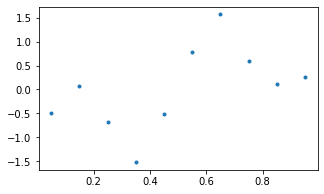

In [8]:
N = 10
X = np.linspace(0.05, 0.95, N).reshape(-1, 1)
Y = -np.cos(np.pi * X) + np.sin(4 * np.pi * X) + \
    np.random.normal(loc=0.0, scale=0.1, size=(N, 1))
plt.figure(figsize=(5, 3))
plt.plot(X, Y, '.')

#### 1. Define covariance function

The most popular kernel - RBF kernel - has 2 parameters: `variance` and `lengthscale`, $k(x, y) = \sigma^2 \exp\left ( -\dfrac{\|x - y\|^2}{2l^2}\right )$,
where `variance` is $\sigma^2$, and `lengthscale` - $l$.

In [9]:
input_dim = 1
variance = 1
lengthscale = 0.2
kernel = GPy.kern.RBF(input_dim, variance=variance,
                      lengthscale=lengthscale)

#### 2. Create GPR model


Name : GP regression
Objective : 13.432394856668715
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    0.2  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f0a9c0bec50>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f0a97802198>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f0a9c0be438>]}

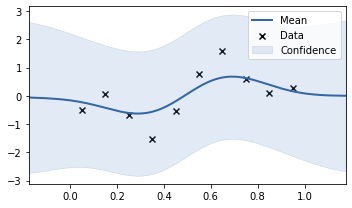

In [10]:
model = GPy.models.GPRegression(X, Y, kernel)
print(model)
model.plot(figsize=(5, 3))

### Parameters of the covariance function

Values of parameters of covariance function can be set like:  `k.lengthscale = 0.1`.

Let's change the value of `lengthscale` parameter and see how it changes the covariance function.

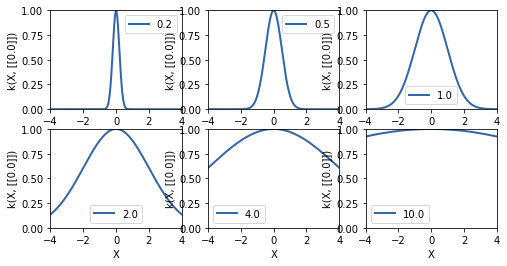

In [11]:
k = GPy.kern.RBF(1)
theta = np.asarray([0.2, 0.5, 1, 2, 4, 10])
figure, axes = plt.subplots(2, 3, figsize=(8, 4))
for t, ax in zip(theta, axes.ravel()):
    k.lengthscale = t
    k.plot(ax=ax)
    ax.set_ylim([0, 1])
    ax.set_xlim([-4, 4])
    ax.legend([t])

Let's try to change parameters to obtain more accurate model (we fix noise variance to some more correct value).

In [11]:
kernel = GPy.kern.RBF(1, lengthscale=0.1)
model = GPy.models.GPRegression(X, Y, kernel)


Name : GP regression
Objective : 9.557024298143167
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    0.1  |      +ve      |        
  Gaussian_noise.variance  |   0.01  |   +ve fixed   |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f0a9c0ced68>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f0a9c14c198>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f0a9c0e9278>]}

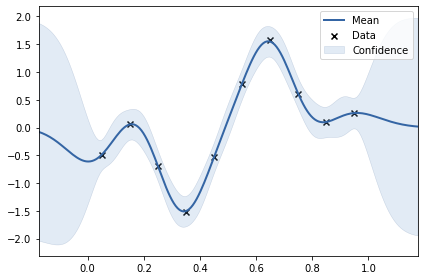

In [13]:
model.Gaussian_noise.variance.fix(0.01)
print(model)
model.plot()

### Tuning parameters of the covariance function

The parameters are tuned by maximizing likelihood. To do it just use `optimize()` method of the model.


Name : GP regression
Objective : 8.974554418741747
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     0.6839367102956523  |      +ve      |        
  rbf.lengthscale          |    0.10423125422905852  |      +ve      |        
  Gaussian_noise.variance  |  8.975641401359725e-05  |      +ve      |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f0a9ed55a20>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f0a9ed38048>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f0a9ed55eb8>]}

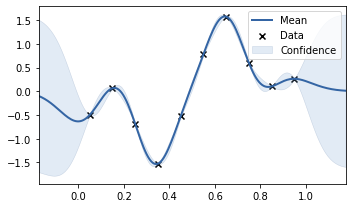

In [14]:
model = GPy.models.GPRegression(X, Y, kernel)
model.optimize()
print(model)
model.plot(figsize=(5, 3))

### Noise variance

Noise variance acts like a regularization in GP models. Larger values of noise variance lead to more smooth model.  
Let's check it: try to change noise variance to some large value, to some small value and see the results.

Noise variance accessed like this: `model.Gaussian_noise.variance = 1`

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f0a9deca9b0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f0a9de7ec88>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f0a9deca710>]}

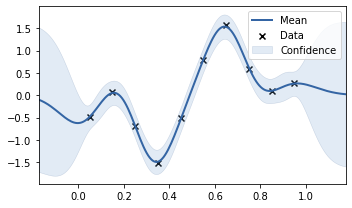

In [18]:
model.Gaussian_noise.variance = 0.01
model.plot(figsize=(5, 3))

Now, let's generate more noisy data and try to fit model.


Name : GP regression
Objective : 42.267728081636506
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   0.8045498670488298  |      +ve      |        
  rbf.lengthscale          |   0.0939546841886617  |      +ve      |        
  Gaussian_noise.variance  |  0.28412491076712904  |      +ve      |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x7faad008ca58>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7faad0091278>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7faad008c748>]}

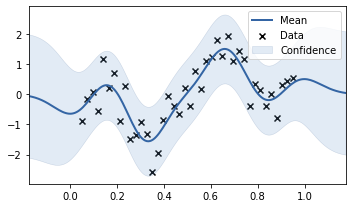

In [13]:
N = 40
X = np.linspace(0.05, 0.95, N).reshape(-1, 1)
Y = -np.cos(np.pi * X) + np.sin(4 * np.pi * X) + \
    np.random.normal(loc=0.0, scale=0.5, size=(N, 1))

kernel = GPy.kern.RBF(1)
model = GPy.models.GPRegression(X, Y, kernel)
model.optimize()
print(model)
model.plot(figsize=(5, 3))

Now, let's fix noise variance to some small value and fit the model


Name : GP regression
Objective : 51.324220122157584
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    0.8866553902309096  |      +ve      |        
  rbf.lengthscale          |  0.016448518291498043  |      +ve      |        
  Gaussian_noise.variance  |                  0.01  |   +ve fixed   |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x7faad008c2e8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7faacfc0b470>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7faacfbf3f28>]}

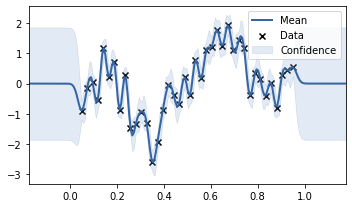

In [14]:
kernel = GPy.kern.RBF(1)
model = GPy.models.GPRegression(X, Y, kernel)
model.Gaussian_noise.variance.fix(0.01)
model.optimize()
print(model)
model.plot(figsize=(5, 3))

## How to explore the function of interest via GP?

### Setting
* Suppose that we have $n$ evaluations of our function of interest $y = f(\mathbf{x}) + \varepsilon$, $ \varepsilon\sim\mathcal N(0,\sigma^2)$:

$$
\mathcal D_{n} = \{(\mathbf{x}_i,y_i),\; i = 1,\ldots,n\}.
$$
* And we want to know which points $\mathbf{x}_{n+1},\mathbf{x}_{n+2},\ldots$ to sample and evaluate the function at them in order to find maximum/minimum of $f(\mathbf{x})$ or reduce an approximation error.

### Active Learning (general algorithm)
1. **for** $t=n+1,\,n+2,\ldots$
2. Find $\mathbf{x}_t$ by combining attributes of the posterior distribution in a **utility function** $u(x \mid \mathcal D_{t-1})$ and maximizing: $x_t = \text{argmax}_\mathbf{x} u(\mathbf x\mid\mathcal D_{t-1})$.
3. Sample the function $y_t = f(\mathbf{x}_t) + \varepsilon_t$.
4. Augment the data $\mathcal D_t = \{D_{t-1},(\mathbf{x}_t,y_t)\}$ and update the GP.
5. **end for**

* In the example below, we explore the function of interest 
$$
f(x)=\frac12\cos(2x)+\sin(0.9x)
$$
with the use of GPR for two sampling approaches: random and adaptive with maximization of an utility function. Also, approximation error is considered and compared.

* The utility function is just a value of standard deviation of GP $u(\mathbf x\mid\mathcal D_{t-1}) = \sigma(\mathbf{x})$. 

* We can change 4 parameters: $\ell$ is the correlation length, $N$ and $n$ are the number of training and test points, correspondingly, $\sigma$ is the amount of noise at each point.

In [45]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import GPy
from ipywidgets import interactive, interact, widgets
import scipy.spatial as SP

from scipy.stats import norm


def GP(length_scale, n, N, sigma, mode):
    # mode: if 0 -- active learning, if 1 -- random selection
    np.random.seed(42)

    Xtest = np.linspace(-5, 5, n)[:, None]

    def f(x): return 0.5*np.cos(2*x.flatten())+np.sin(0.9*x.flatten())

    def kernel(a, b):
        return np.exp(-.5*SP.distance.cdist(a, b, 'sqeuclidean') / (length_scale**2))

    def fitting(X, num_of_points):
        y  = f(X) + sigma*np.random.randn(num_of_points)
        K  = kernel(X, X)
        L  = np.linalg.cholesky(K + sigma*np.eye(num_of_points))
        Lk = np.linalg.solve(L, kernel(X, Xtest))
        mu = np.dot(Lk.T, np.linalg.solve(L, y))
        K_ = kernel(Xtest, Xtest)
        s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
        s  = np.sqrt(s2)
        return y, mu, s

    err_act = []
    err_rand = []

    for t in range(1, N+1):
        mu_act = 0
        if t == 1:
            X_act = np.random.uniform(-5, 5, size=(1, 1))
            _, _, s_act = fitting(X_act, t)
            X_act = np.append(
                X_act, Xtest[np.argmax(s_act)]).reshape(t+1, 1)
        else:
            y_act, mu_act, s_act = fitting(X_act, t)
            X_act = np.append(
                X_act, Xtest[np.argmax(s_act)]).reshape(t+1, 1)
        err_act.append(np.linalg.norm(f(Xtest)-mu_act, ord=np.inf) /
                       np.linalg.norm(f(Xtest), ord=np.inf))

    X_rand = np.random.uniform(-5, 5, size=(N, 1))
    y_rand, mu_rand, s_rand = fitting(X_rand, N)
    for t in range(1, N+1):
        mu_rand = 0
        X_rand_t = np.copy(X_rand[:t])
        _, mu_rand, _ = fitting(X_rand_t, t)
        err_rand.append(np.linalg.norm(f(Xtest)-mu_rand,
                                       ord=np.inf)/np.linalg.norm(f(Xtest), ord=np.inf))

    if mode == 'Adaptive sampling':
        y = y_act
        X = X_act[:N]
        mu = mu_act
        s = s_act
    else:
        y = y_rand
        X = X_rand
        mu = mu_rand
        s = s_rand

    plt.figure(1, figsize=(9, 7))
    plt.clf()
    plt.plot(X, y, 'r+', ms=18, label="Training points")
    plt.plot(Xtest, f(Xtest), 'b-', label="Function")
    plt.fill_between(Xtest.flat, mu-s, mu+s, color="#dddddd",
                     label="Confidence interval")
    plt.plot(Xtest, mu, 'r--', lw=2, label="Approximation")
    plt.fill_between(Xtest.flat, s-3., -3*np.ones(len(Xtest)),
                     color="green", alpha=0.1)
    plt.plot(Xtest.flat, s-3., 'g-', lw=2, label="Acquisition function")
    plt.title("Error (inf. norm) = " + str(round(np.linalg.norm(f(Xtest)-mu, ord=np.inf) /
                                                 np.linalg.norm(f(Xtest), ord=np.inf), 4)))  # (r'Mean prediction plus-minus one s.d.')
    plt.xlabel('$x$', fontsize=16)
    plt.ylabel('$f(x)$', fontsize=16)
    plt.axis([-5, 5, -3, 3])
    plt.legend()
    #print("Error (inf. norm) = ", np.linalg.norm(f(Xtest)-mu, ord=np.inf)/np.linalg.norm(f(Xtest), ord=np.inf))

    plt.figure(2, figsize=(8, 6))
    plt.clf()
    plt.plot(range(1, N+1), err_rand, '-o', label="Random Choice")
    plt.plot(range(1, N+1), err_act, '-o', label="Active Learning")
    plt.xlabel('$N$ number of training points', fontsize=12)
    plt.ylabel('$\epsilon$ approxiamtion error', fontsize=12)
    plt.axis([1, N+0.5, 0.001, 1.1])
    plt.yscale('log')
    plt.legend()
    plt.grid()
    plt.show()


controls = {r'sigma': widgets.FloatSlider(min=5e-4, max=5e-1, step=1e-3, value=1e-3, continuous_update=True, description=r'$\sigma$'),
            r'length_scale': widgets.FloatSlider(min=0.1, max=2.0, step=0.05, value=0.7, continuous_update=True, description=r'$\ell$'),
            r'N': widgets.IntSlider(min=1, max=50, step=1, value=5, continuous_update=True, description=r'$N$'),
            r'n': widgets.IntSlider(min=1, max=100, step=1, value=50, continuous_update=True, description=r'$n$'),
            r'mode': widgets.RadioButtons(options=['Adaptive sampling', 'Random sampling'], value='Adaptive sampling', description='Sampling:', disabled=False)}

In [46]:
interact(GP, **controls);  

interactive(children=(FloatSlider(value=0.7, description='$\\ell$', max=2.0, min=0.1, step=0.05), IntSlider(va…

# When Bayesian optimization?

* Optimization of "heavy" functions 
* The target function is a blackbox, typically noisy, while smooth


* Construction a regression model using available data
* Take into account uncertainty of the regression model
* Gaussian process regression is OK

## Optimization workflow:
1. Construct a regression model $\hat{f}(x)$ of a function $f(x)$ using the sample $D = \{(x_i, f(x_i))\}_{i = 1}^n$
2. Select a new point that maximize an acquisition function
$$
x_{new} = \arg\max\limits_x a(x)
$$
3. Calculate $\hat f(x_{new})$ at the new point.
4. Add the pair $(x_{new}, \hat f(x_{new}))$ to the sample $D$.
5. Update the model $\hat{f}(x)$ and go to step 2.

### Exploration-exploitation trade-off

* In order to find the maximum, we should choose the next input $\mathbf{x}$ where the mean $\mu(\mathbf{x})$ is high (exploitation) and the variance $\sigma(\mathbf{x})$ is high (exploration) as well.
* This trade-off is accounted in the **acquisition** (or **utility**) function.

* Popular utility functions: **probability of improvement**, **expected improvement**, **GP-UCB**.  

## Examples of the acquisition functions 

#### Upper confidence bound (UCB) 

$$
UСB(x) = \hat{\mu}(x) + \beta \hat{\sigma}(x),
$$
$\hat{f}(x), \hat{\sigma}(x)$ - mean and standard deviation of the Gaussian process regression model at $x$.

#### Expected Improvement (EI) 

$$
EI(x) = \mathbb{E}_{p(\hat{f})} \max(0, f_{min} - \hat{f}(x)). 
$$


Usually we use logarithm of EI.

<img src="figures/EI_vs_logEI.png">

# 2. Bayesian optimization libraries:

| Library        | #commits           | #stars | #last commit |
| ------------- | -----:| -----:| -----:|
| hyperopt      | 972   | 3798  | 28.05.2019 | 
| BayesOpt      | 518   | 222   | 28.08.2018 | 
| GPyOpt        | 485   | 515   | 25.09.2019 |
| GPflowOpt     | 426   | 191   | 12.09.2018 | 
| pyGPGO        | 292   | 158   | 15.06.2019 | 

More libraries for Matlab (SUMO) and other languages.

*Actually it is not hard to write your own library on top of your favorite Gaussian Process Regression library.*

## Additional libraries

We need libraries for
* Gaussian process regression **GPy** (see previous seminar)
* Gaussian process regression-based Bayesian optimization **GPyOpt**

See more use cases of **GPyOpt** at http://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/master/manual/index.ipynb

In [42]:
import GPy
import GPyOpt
import matplotlib.pyplot as plt
import numpy as np

# auxiliary functions
import utility
%matplotlib inline
from IPython.display import clear_output
import utility

# emcee sampler is required to run Entropy search in GPyOpt

# 3. One dimensional example

We demonstrate concepts using one-dimensional example.

Let us consider Bayesian optimization for one-dimensional function **Forrester**:
$$
f(x) = (6 x - 2)^2 \sin(12 x - 4).
$$

The optimization problem is the following:
$$
f(x) \rightarrow \min, x \in [0, 1].
$$

In [26]:
# we can load it from GPyOpt library
forrester_function = GPyOpt.objective_examples.experiments1d.forrester()

In [27]:
forrester_function.f(np.array([0.5]))

array([[0.90929743]])

In [28]:
forrester_function.bounds

[(0, 1)]

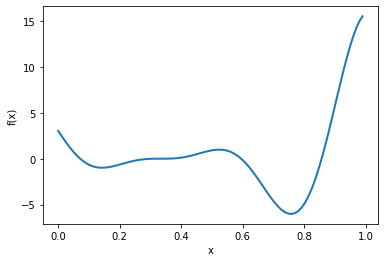

In [29]:
forrester_function.plot()

In [30]:
# Select the region where we search the optimum
space = [{'name': 'x', 'type': 'continuous', 'domain': (0, 1)}]
design_region = GPyOpt.Design_space(space=space)

In [31]:
# Select the initial design
from numpy.random import seed # fixed seed
seed(123456)

initial_sample_size = 5
initial_design = GPyOpt.experiment_design.initial_design('random', design_region, initial_sample_size)

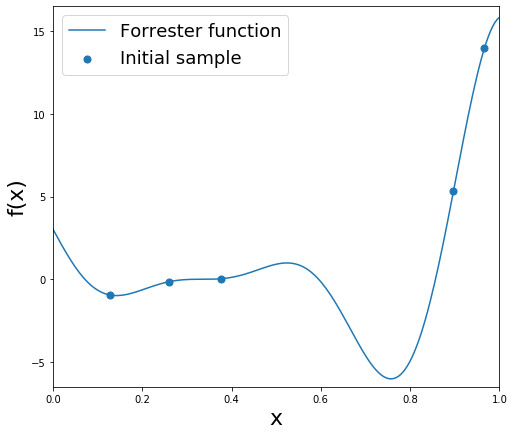

In [32]:
uniform_dense_grid = np.linspace(0, 1, 200).reshape(-1, 1)

# plot function: curve and values at the initial design points
utility.plot_one_dimensional_function(forrester_function, 
                                      uniform_dense_grid, 
                                      initial_design)

## We defined the problem - now we create a machine to solve it

1. A black box that evaluates the target function
2. What kind of the regression model we need
3. How do we optimize the acquisition function
4. What kind of the acquisition function we use
5. Should we use optimizer in batch or continuous mode?

In [33]:
# The target function
objective = GPyOpt.core.task.SingleObjective(forrester_function.f)

# Model type
gp_model = GPyOpt.models.GPModel(exact_feval=True, optimize_restarts=10, verbose=False) 
# exact_feval - are evaluations exact?
# optimize_restarts - number of restarts at each step
# verbose - how verbose we are

# Optimizer of the acquisition function, the default is 'LBFGS'
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(design_region)

# The acquisition function is expected improvement
acquisition_function = GPyOpt.acquisitions.AcquisitionEI(gp_model, design_region, optimizer=aquisition_optimizer)

# How we collect the data
evaluator = GPyOpt.core.evaluators.Sequential(acquisition_function)

In [34]:
# Now we are ready to construct the machine
bayesian_optimizer = GPyOpt.methods.ModularBayesianOptimization(gp_model, design_region, objective, 
                                                acquisition_function, evaluator, initial_design)

### Run the first six iterations

In [35]:
# Stopping criteria
max_time = None 
max_number_of_iterations = 5
tolerance = 1e-8 # distance between consequitive observations

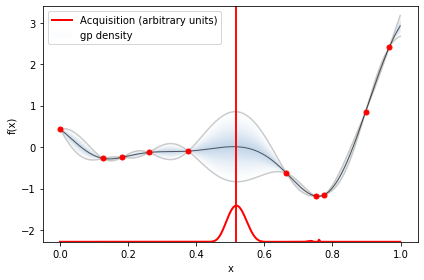

In [36]:
# Run five iterations
for iteration in range(max_number_of_iterations):
    bayesian_optimizer.run_optimization(max_iter=1, max_time=max_time, 
                                        eps=tolerance, verbosity=False) 
  
    bayesian_optimizer.plot_acquisition()
    clear_output(wait=True)

### Now we run more iterations - 25

In [37]:
bayesian_optimizer = GPyOpt.methods.ModularBayesianOptimization(gp_model, design_region, objective, 
                                                acquisition_function, evaluator, initial_design)

max_number_of_iterations = 25
bayesian_optimizer.run_optimization(max_iter=max_number_of_iterations, max_time=max_time, 
                                    eps=tolerance, verbosity=False)

### Analyze problems

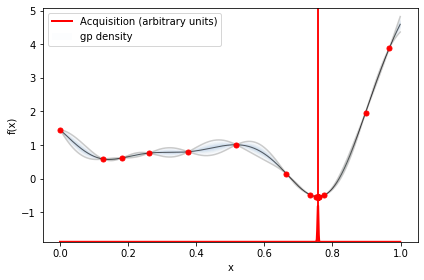

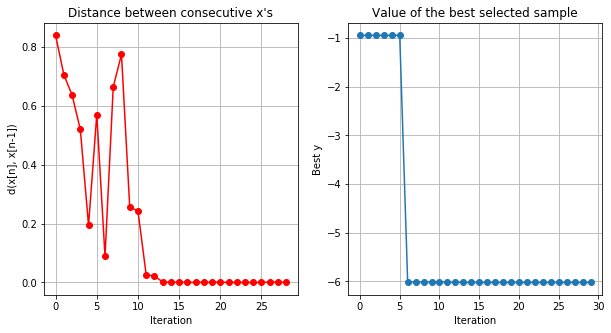

In [38]:
bayesian_optimizer.plot_acquisition()
bayesian_optimizer.plot_convergence()

In [39]:
print('Obtained xmin:  %.3f, real xmin:  %.3f (approximate)' % (bayesian_optimizer.x_opt, forrester_function.min))
print('Obtained fmin: %.3f, real fmin: %.3f (approximate)' % (bayesian_optimizer.fx_opt, forrester_function.fmin))

Obtained xmin:  0.757, real xmin:  0.780 (approximate)
Obtained fmin: -6.021, real fmin: -6.000 (approximate)
